In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
import os
import sqlalchemy
from sqlalchemy import create_engine
import pipeline_plan_functions.utils.db_handler as dbh
from python_utils.utils.logger import logger
import alloc_functions.allocation_scenario as asf
import alloc_functions.controller as acf
import alloc_functions.daily as adf
import alloc_functions.cleanup as cleaner
import alloc_functions.mixed as mixed
import pipeline_plan_functions.utils.data_handler as dh
import matplotlib.pyplot as plt
import json
from pulp import *
import itertools
import pytz
import matplotlib.pyplot as plt
fps_colours = ['#004A9C', '#45D281', '#FEC001','#A365E0', '#5B9BD5',

               '#FF0000', '#0563C1', '#954F72']

In [2]:
run = 22
allocations = np.arange(67, 81)
cnx = dbh.create_alch_engine()
connection, cur = dbh.database_connection('test')
allocations

array([67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

In [5]:
for idx in allocations[:1]:
    alloc = adf.get_allocation(idx, cnx)
    # Get date range
    date_range = find_unallocated_dates(idx, connection, cur)
    # print(idx, '# dates', len(date_range))
    # for date in date_range:
    #     try:
    #         adf.daily(date, alloc, cnx, connection, cur)
    #     except Exception as e:
    #         logger.error(e)

In [3]:
cnx.dispose()
cur.close()
connection.close()

NameError: name 'cnx' is not defined

In [3]:
connection, cur = dbh.database_connection('test')
cnx = dbh.create_alch_engine()
run = dh.get_current_run(connection, cur)
# Read the allocation table, find the last one
alloc, not_last = asf.find_current_allocation(run, cnx)
# Get the journeys
routes = asf.get_return_routes(alloc['route_table'], alloc['site_id'],
                        alloc['start_date'], alloc['end_date'], cnx)

2022-04-20 20:56:33|DEBUG|data_handler.py(21)|get_current_run|Current run 22
2022-04-20 20:56:34|DEBUG|allocation_scenario.py(31)|find_current_allocation|Current allocation ID: 67


In [11]:
routes.head()

,client_id,site_id_start,departure_time,arrival_time,vehicle_id,distance_miles,route_id,payload,number_crates,number_order,driving_time,site_id_end,source,date
0,5,189,2020-12-03 08:08:50,2020-12-03 11:04:34,8441,22.374145,11351,NaN,None,14,None,189,1,2020-12-03
1,5,189,2020-12-03 11:50:44,2020-12-03 14:27:02,8441,23.244251,11352,NaN,None,14,None,189,1,2020-12-03
2,5,189,2020-12-03 15:43:30,2020-12-03 21:23:39,8441,56.494717,11353,NaN,None,26,None,189,1,2020-12-03
3,5,189,2020-12-04 08:42:51,2020-12-04 13:53:10,8441,39.962710,11354,NaN,None,21,None,189,1,2020-12-04
4,5,189,2020-12-04 15:23:13,2020-12-04 21:15:57,8441,44.686140,11355,NaN,None,25,None,189,1,2020-12-04


In [23]:
routes.groupby('date').agg({
    'vehicle_id': 'nunique'
}).sort_values(by='vehicle_id')

,vehicle_id
date,
2020-12-24,1
2021-01-25,8
2021-04-01,9
2021-04-02,9
2021-04-03,9
...,...
2021-10-15,13
2021-10-25,13
2021-09-30,13


In [146]:
TIME_INT_IS = dt.timedelta(minutes=30)
N = int(dt.timedelta(days=1)/TIME_INT_IS)
POTENTIAL_TPS_IS = [i*TIME_INT_IS for i in range(N)]
TP_FRACT_IS = TIME_INT_IS/dt.timedelta(hours=1)
def find_allocation(idx, cnx):
    try:
        sql_query = f"""SELECT * FROM t_allocation WHERE allocation_id={idx} LIMIT 1"""
        current_allocation = pd.read_sql_query(sql_query, cnx).iloc[0].to_dict()
    except (Exception, psycopg2.Error) as error:
        logger.error(f"Error while fetching current allocation")
        raise(error)
    return current_allocation
range_wltp = {
    'ducatolr': 138,
    'e9': 185,
    'vivarolr': 205
}
payload = {
    'ducatolr': 765,
    'e9': 860,
    'vivarolr': 1002
}
colors = {
    'ducatolr': fps_colours[4],
    'e9': fps_colours[3],
    'vivarolr': fps_colours[5]
}
name = {
    'ducatolr': "eDucato",
    'e9': "e9",
    'vivarolr': "eVivaro"
}

In [147]:
connection, cur = dbh.database_connection('test')
cnx = dbh.create_alch_engine()

In [152]:
alloc = find_allocation(35, cnx)
alloc['turnaround'], alloc['min_to_connect'] = adf.get_turnaround_time(alloc['site_id'], cnx)
routes = cleaner.get_allocated_routes(alloc['allocation_id'], cnx).sort_index()
routes = cleaner.get_daily_route_data(routes, alloc, cnx)

alloc2 = find_allocation(40, cnx)
routes2 = cleaner.get_allocated_routes(alloc2['allocation_id'], cnx).sort_index()
routes2 = cleaner.get_daily_route_data(routes2, alloc2, cnx)
mask_diff = routes['allocated_spec_id'] != routes2['allocated_spec_id']
vr1 = routes[routes2['allocated_vehicle_id']==23]
vr2 = routes2[routes2['allocated_vehicle_id']==23]
idxs = routes2[(routes2['allocated_vehicle_id']==23)
        & (routes2['date']==dt.datetime(2021, 10, 25))].sort_values(by='shift').index
routes2.loc[idxs][['allocated_vehicle_id', 'energy_required_kwh', 'route_cost',
                   'departure_time', 'arrival_time', 'distance_miles']]

,allocated_vehicle_id,energy_required_kwh,route_cost,departure_time,arrival_time,distance_miles
route_id,,,,,,
1471,23,39.878049,1.0,2021-10-25 06:15:00,2021-10-25 12:35:00,109.0
1454,23,14.268293,1.0,2021-10-25 14:30:00,2021-10-25 16:17:00,39.0
1485,23,28.170732,0.5,2021-10-25 18:00:00,2021-10-25 22:04:00,77.0


In [109]:
shiftidx = adf.separate_shift_idsx(routes)
first_routes = routes.loc[shiftidx[1]]
secondJourneys = routes.loc[shiftidx[2]]

In [164]:
alloc = find_allocation(109, cnx)
routes = cleaner.get_allocated_routes(alloc['allocation_id'], cnx)
routes = cleaner.get_daily_route_data(routes, alloc, cnx).sort_index()
routes['category'] = 'x'
grouped = mixed.group_routes(routes)
turn = 75
charging_rate = 50*0.9
for idx in grouped.index:
    masklist = []
    dutyR = routes[(routes['date'] == idx[0])
                        & (routes['allocated_vehicle_id'] == idx[1])].index
    # Calculate IS shifts
    for r in dutyR:
        masklist.append(mixed.tp_journeys(routes.loc[r], turn))
    masklist.append(np.array(POTENTIAL_TPS_IS)
                        > (grouped.loc[idx, 'departure_time']-grouped.loc[idx, 'route_date']))
    masklist.append(np.array(POTENTIAL_TPS_IS)
                        < (grouped.loc[idx, 'arrival_time']-grouped.loc[idx, 'route_date']))
    n = len(masklist)
    tps = np.sum(np.vstack(masklist).sum(axis=0) == n)
    grouped.loc[idx, 'TPs'] = tps
average_kwh_mile = 0.47
grouped['extra_mileage'] = grouped['TPs']*TP_FRACT*charging_rate/average_kwh_mile
grouped['reduced_mileage'] = (grouped['equivalent_mileage']-grouped['extra_mileage']).clip(
    lower=grouped['IndMileage'])

In [165]:
vehicles = ['vivarolr', 'e9', 'ducatolr']
for i in range(3):
    grouped[f'unfeasible_noIS_{i}'] = grouped['equivalent_mileage'] >= range_wltp[vehicles[i]]
    grouped[f'unfeasible_is_{i}'] = grouped['reduced_mileage'] >= range_wltp[vehicles[i]]
26-grouped.groupby('date').agg({
    'unfeasible_noIS_0': 'sum',
    'unfeasible_is_0': 'sum',
    'unfeasible_noIS_1': 'sum',
    'unfeasible_is_1': 'sum',
    'unfeasible_noIS_2': 'sum',
    'unfeasible_is_2': 'sum'
}).max()
# grouped

unfeasible_noIS_0    16
unfeasible_is_0      26
unfeasible_noIS_1    11
unfeasible_is_1      25
unfeasible_noIS_2     4
unfeasible_is_2      23
dtype: int64

In [169]:
count_array = np.full((3,3), 0)
vehicles = ['vivarolr', 'e9', 'ducatolr']
for i in range(3):
    # Number feasible without IS
    count_array[0][i] = (grouped['equivalent_mileage'] < range_wltp[vehicles[i]]).sum()
    # Number feasible only with IS
    count_array[1][i] = ((grouped['equivalent_mileage'] >= range_wltp[vehicles[i]])
                         & (grouped['reduced_mileage'] < range_wltp[vehicles[i]])).sum()
    # NUmber unfeasible
    count_array[2][i] = ((grouped['reduced_mileage'] >= range_wltp[vehicles[i]])).sum()
count_array

array([[377, 304, 159],
       [169, 239, 365],
       [  0,   3,  22]])

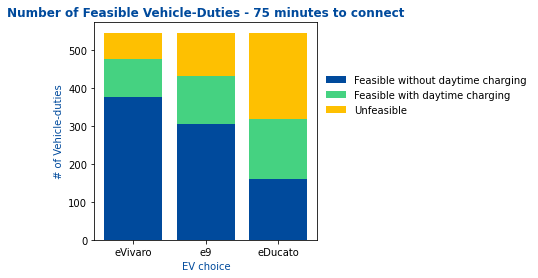

In [129]:
fig, ax = plt.subplots(1, figsize=(4, 4))
xlabels = [name[v] for v in vehicles]
ax.bar(x = xlabels,
    height=count_array[0],
    color=[fps_colours[0]], label='Feasible without daytime charging')
ax.bar(x = xlabels,
    height=count_array[1], bottom=count_array[0],
    color=[fps_colours[1]], label='Feasible with daytime charging')
ax.bar(x = xlabels,
    height=count_array[2], bottom=count_array[1]+count_array[0],
    color=[fps_colours[2]], label='Unfeasible')
ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_xlabel('EV choice', color=fps_colours[0])
ax.set_ylabel('# of Vehicle-duties', color=fps_colours[0])
ax.set_title(
    f"Number of Feasible Vehicle-Duties - {turn} minutes to connect",
    color=fps_colours[0], fontweight='bold')
fig.savefig(
    f"C:/Users/SofiaTaylor/OneDrive - Flexible Power Systems Ltd/Consulting/SSL/Argos meeting/feasibility_{turn}minutes.png",
    bbox_inches="tight", dpi=300)

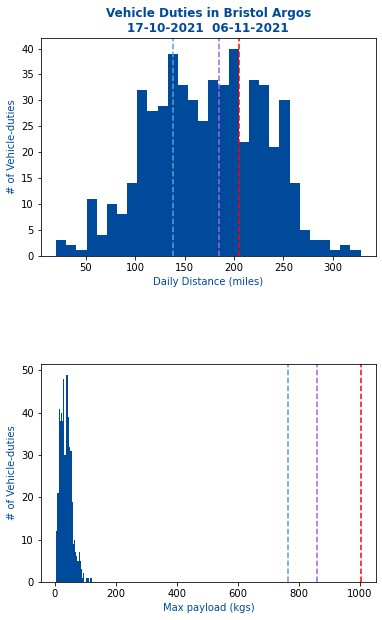

In [130]:

# range_observed = 155

fig, ax = plt.subplots(
    2, figsize=(6, 10), gridspec_kw={'hspace': 0.5})
ax[0].hist(
    grouped['distance_miles'],
    bins=30,
    color=[fps_colours[0]])

ax[1].hist(
    grouped['payload'],
    bins=30,
    color=[fps_colours[0]])

ax[0].set_xlabel('Daily Distance (miles)', color=fps_colours[0])
ax[0].set_ylabel('# of Vehicle-duties', color=fps_colours[0])
for v in name.keys():
    ax[0].axvline(x=range_wltp[v], label=name[v], ls='--', color=colors[v])
# ax.axvline(x=range_observed, label='Observed', ls='--', color=fps_colours[2])
# ax[0].legend(frameon=False, bbox_to_anchor=(1, 0.8))

ax[1].set_xlabel('Max payload (kgs)', color=fps_colours[0])
ax[1].set_ylabel('# of Vehicle-duties', color=fps_colours[0])
for v in name.keys():
    ax[1].axvline(x=payload[v], label=name[v], ls='--', color=colors[v])

ax[0].set_title(
    "Vehicle Duties in Bristol Argos\n17-10-2021  06-11-2021",
    color=fps_colours[0], fontweight='bold')
fig.savefig(
    f"C:/Users/SofiaTaylor/OneDrive - Flexible Power Systems Ltd/Consulting/SSL/Argos meeting/combined_duties_alloc{alloc['allocation_id']}.png",
    bbox_inches="tight", dpi=300)

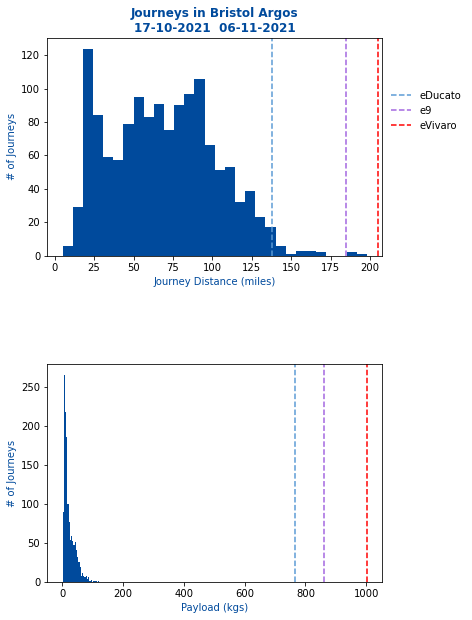

In [131]:
fig, ax = plt.subplots(
    2, figsize=(6, 10), gridspec_kw={'hspace': 0.5})
ax[0].hist(
    routes['distance_miles'],
    bins=30,
    color=[fps_colours[0]])

ax[1].hist(
    routes['payload'],
    bins=30,
    color=[fps_colours[0]])

ax[0].set_xlabel('Journey Distance (miles)', color=fps_colours[0])
ax[0].set_ylabel('# of Journeys', color=fps_colours[0])
for v in name.keys():
    ax[0].axvline(x=range_wltp[v], label=name[v], ls='--', color=colors[v])
# ax.axvline(x=range_observed, label='Observed', ls='--', color=fps_colours[2])
ax[0].legend(frameon=False, bbox_to_anchor=(1, 0.8))

ax[1].set_xlabel('Payload (kgs)', color=fps_colours[0])
ax[1].set_ylabel('# of Journeys', color=fps_colours[0])
for v in name.keys():
    ax[1].axvline(x=payload[v], label=name[v], ls='--', color=colors[v])

ax[0].set_title(
    "Journeys in Bristol Argos\n17-10-2021  06-11-2021",
    color=fps_colours[0], fontweight='bold')
fig.savefig(
    f"C:/Users/SofiaTaylor/OneDrive - Flexible Power Systems Ltd/Consulting/SSL/Argos meeting/journeys_alloc{alloc['allocation_id']}.png",
    bbox_inches="tight", dpi=300)

## Controller

In [2]:
connection, cur = dbh.database_connection('test')
cnx = dbh.create_alch_engine()
# FIND THE MOST UP TO DATE RUN ID
run = rh.get_current_run(connection, cur)
# Get run input parameters
inputs = rh.get_inputs('t_run_allocation', run, connection, cur)
df = acf.create_allocation_table(inputs, connection, cur)
for idx in df.index:
    vehicle_pool = acf.select_vehicles(
        df.loc[idx, 'site_id'], df.loc[idx, 'vehicle_pool'], connection, cur)
    # Order vehicles
    df.at[idx, 'vehicle_pool'] = acf.order_items(
        vehicle_pool, 't_vehicle_specification', 'spec_id', 'vehicle_purchase_price',
        connection, cur)

2022-03-18 09:43:49,133|DEBUG|run_handler.py(19)|get_current_run|Current run 2
2022-03-18 09:43:49,169|DEBUG|run_handler.py(35)|get_inputs|read inputs for run 2
2022-03-18 09:43:49,176|DEBUG|controller.py(49)|get_fps_allocation_id|reading last allocation ID


## Allocation scenario

In [4]:
cnx = dbh.create_alch_engine()
connection, cur = dbh.database_connection('test')
alloc, not_last = asf.find_current_allocation(2, cnx)
routes = asf.get_return_routes(alloc['site_id'], alloc['start_date'], alloc['end_date'], cnx)
numJ = len(routes)  # TODO save this
site_data = asf.get_site_data(alloc['site_id'], cnx)
# Assign shifts
routes['shift'] = asf.set_shifts(site_data['shift_starts'], routes)
routes['fixed_arrival'] = routes['arrival_time'] + dt.timedelta(minutes=site_data['turnaround_time'])
routes['allocation_id'] = alloc['allocation_id']
xmpg = site_data['xmpg']*(1+alloc['xmpg_change']/100)
vehicle_specs = asf.get_vehicle_specs(alloc['vehicle_pool'], cnx)
# Select vehicles (if only one in pool, just that)
selectedV = asf.select_vehicle(
    routes, vehicle_specs, xmpg)
feas = asf.feasible_journey(vehicle_specs.loc[selectedV], routes, xmpg)
routes = routes[feas]
numV = asf.num_simultaneous(routes)  # TODO save this


2022-03-17 19:21:16,228|DEBUG|allocation_scenario.py(116)|select_vehicle|Potential Vehicle: 11
2022-03-17 19:21:16,240|DEBUG|allocation_scenario.py(122)|select_vehicle|Best: 11 with 0 routes removed
2022-03-17 19:21:16,271|DEBUG|allocation_scenario.py(140)|num_simultaneous|Number of Vehiclesis 23.0


In [2]:
asf.main()

2022-03-17 19:25:36,739|INFO|allocation_scenario.py(147)|main|Telematics cleaning function called at 2022-03-17 19:25:36.739070
2022-03-17 19:25:37,506|DEBUG|run_handler.py(19)|get_current_run|Current run 2
2022-03-17 19:25:38,138|DEBUG|allocation_scenario.py(31)|find_current_allocation|Current allocation ID: 1
2022-03-17 19:25:38,140|INFO|allocation_scenario.py(160)|main|Closed db connection
2022-03-17 19:25:38,927|DEBUG|allocation_scenario.py(116)|select_vehicle|Potential Vehicle: 11
2022-03-17 19:25:38,935|DEBUG|allocation_scenario.py(122)|select_vehicle|Best: 11 with 2 routes removed
2022-03-17 19:25:38,971|DEBUG|allocation_scenario.py(140)|num_simultaneous|Number of Vehiclesis 23.0
2022-03-17 19:25:39,720|DEBUG|db_handler.py(62)|upload_table|Uploaded to t_route_allocated


True

## Dummy data

In [16]:
sample_veh_specs = pd.read_csv(r'C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\Planning\Samples\sample_vehicle_spec.csv', )

cnx = dbh.create_alch_engine()
sample_veh_specs.to_sql('t_vehicle_specification', con=cnx, if_exists='append', index=False)
cnx.dispose()

In [22]:
sql_query = f"""SELECT * FROM t_route_master WHERE departure_time >= '{alloc['start_date']}'
    AND departure_time < '{alloc['end_date']}'
    AND site_id_start={alloc['site_id']}"""
routes = pd.read_sql_query(sql_query, cnx)
routes['route_id'] += 10000
routes['departure_time'] += dt.timedelta(hours=25)
routes['arrival_time'] += dt.timedelta(hours=25)
routes.to_sql('t_route_master', con=cnx, if_exists='append', index=False)

62